# Predict unobserved properties by help of machine learning

In [1]:
# Standard imports
import numpy as np
import os
import itertools
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
# Scikit learn imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# Plotly
import plotly as py
import plotly.offline as po


## Load DB open dataset
Contains position and state data from containers in transport

In [2]:
# Load data
df = pd.read_csv('http://download-data.deutschebahn.com/static/datasets/sensordaten_schenker/161209_Schenker_Sensordaten.csv')
# First line contains comments
df.drop(0, inplace = True)
# inspect
df.head()

,index,SXXJ number,Container,Date,Time_UTC,Latitude,Longitude,Accuracy,Active,Reverse,...,Door,Mount,Motion,GForce,Tilt,Temperature,Humidity,Light,Origin,Destination
1,0,A,NONE,2016-08-08,14:39:36,NaN,NaN,NaN,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,A,NONE,2016-08-08,14:39:45,NaN,NaN,NaN,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,A,NONE,2016-08-08,14:40:34,25.794100,-80.369301,cellid,0,0,...,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,A,NONE,2016-08-08,15:57:46,NaN,NaN,NaN,1,0,...,0,0,0,0.000,NaN,29.800,75.700,NaN,NaN,NaN
5,4,A,NONE,2016-08-08,15:58:50,25.799700,-80.367302,cellid,1,0,...,0,0,0,0.000,NaN,29.900,73.000,NaN,NaN,NaN


Data cleaning:
- Remove NaN
- Convert strings to numbers

In [3]:
df.dropna(subset=['Latitude', 'Longitude', 'Humidity', 'Temperature'], inplace = True)
df = df[['Latitude', 'Longitude', 'Humidity', 'Temperature']].apply(pd.to_numeric)
df.describe()

,Latitude,Longitude,Humidity,Temperature
count,2136.000000,2136.000000,2136.000000,2136.000000
mean,35.686900,49.061009,53.166526,7.801264
std,17.137498,86.569548,12.958645,16.846114
min,-12.107100,-179.957001,16.800000,-27.200000
25%,30.624100,0.163120,43.000000,-5.425000
50%,41.675800,101.989998,51.750000,6.900000
75%,49.603001,121.899500,63.925000,22.500000
max,57.122700,178.399002,83.800000,47.300000


### Scatter plot, no map background

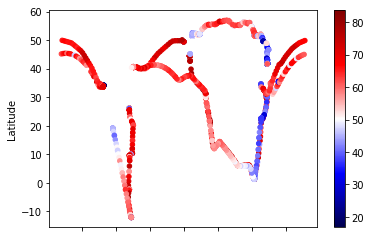

In [9]:
df.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', c = df['Humidity'], cmap = 'seismic')

### Scatter plot on map background

In [5]:
data = [ dict(
        type = 'scattergeo',
        #locationmode = 'Germany',
        lon = df['Longitude'],
        lat = df['Latitude'],
        text = df['Temperature'],
        mode = 'markers',
        marker = dict(
            size = 0.1*df['Humidity'],
            opacity = 0.8,
            #reversescale = True,
            autocolorscale = False,
            #symbol = 'square',
            colorscale = 'Jet',
            color = df['Temperature'],
            #cmax = df['Temperature'].max(),
            colorbar=dict(thickness=20)
        ))]

layout = dict(
        title = 'Observed container temperatures',
        colorbar = dict(),
        geo = dict(
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5,
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ df['Longitude'].min(), df['Longitude'].max() ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ df['Latitude'].min(), df['Latitude'].max() ],
                dtick = 5
            )
        ),
    )

fig = dict( data=data, layout=layout )
po.plot(fig, validate=False, filename='d3-container.html')

'file:///Users/raphael/sciebo/Vorlesungen/xxxxx_MiniWS/ifvMiniWorkshop/d3-container.html'

### Train model to predict frost:
- Split into training and test data
- Scale data
- Fit SVM

In [50]:
from sklearn.model_selection import train_test_split
# Data selection
X = df[['Latitude', 'Longitude']]
# Label target data
y = (df['Temperature'] <0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
# Initialise scaler
scaler = StandardScaler()
# Scale data
X_train_scale = scaler.fit_transform(X_train)
# Initialise support vector machine
svm_clf = SVC(kernel='poly', C = 0.01)#, class_weight = {True: 1, False:0})
# Fit SVM
svm_clf.fit(X_train_scale, y_train)

SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Plot decision surface of classifier

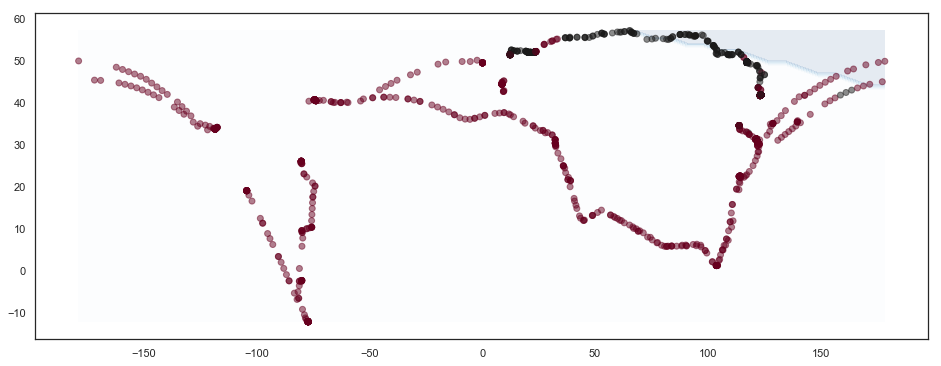

In [69]:
sns.set()
# Plot 3D scatter with decision boundary
from mpl_toolkits.mplot3d import Axes3D
x = X_train['Longitude']
y = X_train['Latitude']
c = y_train*1.0

xx = np.linspace(min(X_train_scale[:,0]), max(X_train_scale[:,0]), 50)
yy = np.linspace(min(X_train_scale[:,1]), max(X_train_scale[:,1]), 50)
[Y, X] = np.meshgrid(xx, yy)
Z = svm_clf.predict(np.c_[X.ravel(), Y.ravel()])
Z = Z.reshape(X.shape)
xx = np.linspace(min(x), max(x), 50)
yy = np.linspace(min(y), max(y), 50)
[X, Y] = np.meshgrid(xx, yy)

with sns.axes_style('white'):
    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_subplot(111)
    ax.contourf(X, Y, Z, cmap = 'Blues', alpha = 0.1)
    ax.scatter(x, y, c = c, cmap = 'RdGy', alpha = 0.5)

### Test on unseen data:

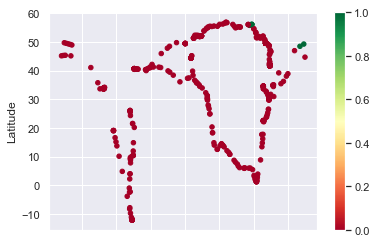

In [70]:
X_test_scale = scaler.transform(X_test)
# Predict 
y_pred = svm_clf.predict(X_test_scale)
# Plot
X_test.plot(x = 'Longitude', y = 'Latitude', kind = 'scatter', c=y_pred.astype(int), cmap = 'RdYlGn')

Inspect confusion matrix

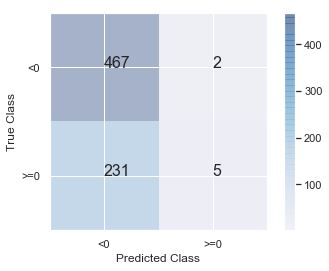

In [71]:
conf_mat = confusion_matrix(1.0*y_test, 1.0*y_pred)
plt.imshow(conf_mat, cmap = plt.cm.Blues, alpha = 0.3)
plt.colorbar()
plt.xticks((0, 1), ("<0", ">=0"))
plt.yticks((0, 1), ("<0", ">=0"))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
for i,j in itertools.product((0,1), (0,1)):
    plt.text(j,i, conf_mat[i,j], fontsize = 16)
